In [ ]:
from utils import plot_cheap, plot_cheap_qmol

In [ ]:
# Fig. 1
plot_cheap(props=['pauling_EN', 'valency'], xlabel='Mean Electronegativity', save=False, annotate=True)

In [ ]:
# Fig. 1.1
plot_cheap(props=['nuclear_charge', 'valency'], xlabel='Mean Nuclear Charge', annotate=True, save=False)

In [ ]:
# Fig 1.2
plot_cheap(props=['atomic_radius', 'valency'], xlabel='Mean Atomic Radius (pm)', save=False, annotate=True)

In [ ]:
plot_cheap_qmol(props=['pauling_EN', 'qmol'], save=True)

# Figures for manuscript

In [ ]:
'''
Figure 4 (original)
'''

from generate_descriptors import generate_descriptors
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

xyz_dir = '/home/alex/Pt_NMR/data/structures/total/'
names = pd.read_csv('/home/alex/Pt_NMR/data/labels/total_set_clean_120525.csv', index_col='List_index')['Name']

gen = generate_descriptors(descriptor_params=[8.0, 8000], descriptor_path='../data/representations/APE_RF/',
                           central_atom='Pt', xyz_path=xyz_dir, xyz_base='st_', normalize=True)

apes = gen.get_APE_RF(format='xyz', mode='all', smooth_cutoff=False)

x = np.linspace(0.0, 8.0, 8000)


plt.plot(x, apes[247], label='$[PtF_{6}]^{2-}$')
plt.plot(x, apes[263], label='$[PtCl_{6}]^{2-}$')
plt.plot(x, apes[48], label='$cis-Pt(py)_{2}I_{2}$')
plt.plot(x, apes[61], label='$cis-Pt(NH_{3})_{2}Ac_{2}$')

plt.grid()
plt.legend()

plt.xlabel('Distance from Pt ($\AA$)')
plt.ylabel('$\Phi(r)$', fontsize=15)

#plt.yticks([])

print(names[247])
print(names[263])
print(names[48])
print(names[61])

plt.savefig('../paper/figs/fig_4.png', dpi=400, bbox_inches='tight')

plt.show()

<>:56: SyntaxWarning: invalid escape sequence '\A'
<>:57: SyntaxWarning: invalid escape sequence '\P'
<>:56: SyntaxWarning: invalid escape sequence '\A'
<>:57: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_169942/2100955018.py:56: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('Distance from Pt ($\AA$)')
/tmp/ipykernel_169942/2100955018.py:57: SyntaxWarning: invalid escape sequence '\P'
  plt.ylabel('$\Phi(r)$', fontsize=15)


(292, 8000)


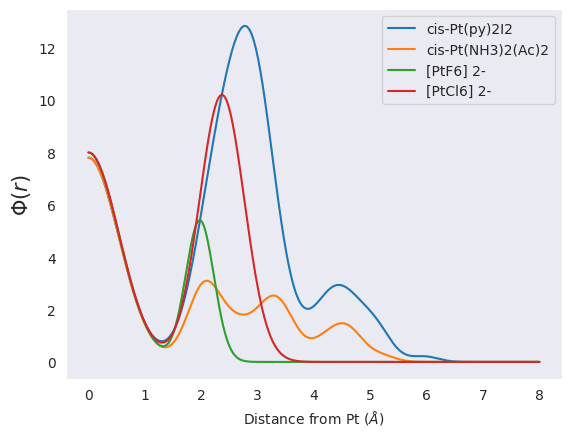

In [1]:
'''
Figure 5 (original)
'''

from hydra import initialize, compose
from data_loader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

with initialize(config_path="../conf", version_base="1.1"):
    cfg = compose(config_name="config")


cfg.representations.rep = 'GAPE'

loader = DataLoader(cfg)
apes = loader.load_samples(partitioned=False)[0]

print(np.shape(apes))

x = np.linspace(0.0, 8.0, 8000)

#apes_train = gen.get_APE_RF_partitioned()[0]
#apes_holdout = gen.get_APE_RF_partitioned()[1]

#apes = np.vstack((apes_train, apes_holdout))

#train_df = pd.read_csv('/home/alex/Pt_NMR/data/labels/train_test_split/indexed_targets_train_copy.csv')
df = pd.read_csv('/home/alex/Pt_NMR/data/labels/total_set_clean_120525.csv')
#df_new = df.sort_values(by='Index')

#print(df_new)

#df_sorted = df.sort_values(by=['Index'])
#df_sorted.to_csv('/home/alex/Pt_NMR/data/labels/train_test_split/indexed_targets_train_copy.csv')

names = df['Name']

plt.plot(x, apes[48], label=names[48])
plt.plot(x, apes[61], label=names[61])
plt.plot(x, apes[247], label=names[247])
plt.plot(x, apes[263], label=names[263])



#plt.plot(x, total_apes[218], label='cis-[Pt(AsEt$_{3}$)$_{2}$Cl_${2}$]')
#plt.plot(x, total_apes[219], label='cis-[Pt(AsEt$_{3}$)$_{2}$Cl_${2}$]')

plt.grid()
plt.legend()

plt.xlabel('Distance from Pt ($\AA$)')
plt.ylabel('$\Phi(r)$', fontsize=15)


#plt.savefig('../paper/figs/fig_5.png', dpi=400, bbox_inches='tight')

plt.show()

In [ ]:
'''
Figure 6 (original with different data)
'''

# Create learning curves for r_cut dependency

from NMR_predict import GPR_NMR
from sklearn.model_selection import learning_curve, ShuffleSplit
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, Exponentiation, WhiteKernel

noise = 1e-3
randomSeed = 42

descriptor_path = ['../data/representations/SOAP/train/', '../data/representations/SOAP/test/']
xyz_path = ['../data/structures/train_split/', '../data/structures/test_split/']
target_path =  ['../data/labels/train_test_split/indexed_targets_train.csv', '../data/labels/train_test_split/indexed_targets_test.csv']



rcut_list = [2.0, 3.0, 4.0, 5.0, 6.0]
train_score_list = []
train_size_list = []
test_score_list = []



for rcut in rcut_list:

    test_mae_list = []

    gpr_nmr = GPR_NMR(descriptor_params=[rcut, 2, 2], descriptor_path=descriptor_path,
                      central_atom='Pt', xyz_path=xyz_path, xyz_base='st_', descriptor_type='SOAP',
                      mode='write', target_path=target_path)

    X_data = gpr_nmr.load_samples()[0]
    target_data = gpr_nmr.load_targets(target_name='Experimental')[0]


    estimator = GaussianProcessRegressor(
                    kernel=Exponentiation(DotProduct(), 2) + WhiteKernel(noise_level=noise),
                    random_state=randomSeed,
                    alpha=0.0, n_restarts_optimizer=10, normalize_y=True)

    # TODO: Does calling estimator.fit() before generating lc make a difference ?

    train_sizes, train_scores, test_scores = learning_curve(estimator, X_data, target_data,
                                                                train_sizes=np.linspace(0.2, 1.0, 5),
                                                                cv=ShuffleSplit(n_splits=4, test_size=0.25,#KFold(n_splits=4, shuffle=True,
                                                                         random_state=42),
                                                                scoring='neg_mean_absolute_error')

    for test_score in test_scores:
        test_mae_list.append(np.mean(test_score))

    test_score_list.append(test_mae_list)

np.savetxt('/home/alex/Pt_NMR/paper/figs/data_for_figs/fig_6_test_scores.txt', test_score_list)
np.savetxt('/home/alex/Pt_NMR/paper/figs/data_for_figs/fig_6_train_sizes.txt', train_sizes)


In [ ]:
"""
Figure 6 (original with different data)
"""

rcut_list = [2.0, 3.0, 4.0, 5.0, 6.0]
color_list = ['k', 'b', 'violet', 'r', 'orange']

test_score_list = np.genfromtxt('/home/alex/Pt_NMR/paper/figs/data_for_figs/fig_6_test_scores.txt')
train_sizes = np.genfromtxt('/home/alex/Pt_NMR/paper/figs/data_for_figs/fig_6_train_sizes.txt')

plt.style.use('default')
fig, ax = plt.subplots()



for rcut, color, test_mae_list in zip(rcut_list, color_list, test_score_list):
    test_mae_list = [abs(test_mae) for test_mae in test_mae_list]
    ax.scatter(train_sizes, test_mae_list, label=f'r={rcut} $\AA$', color=color)
    ax.plot(train_sizes, test_mae_list, color = color)

ax.set_xlabel('Number of training instances')
ax.set_ylabel('MAE (ppm)')

ax.legend()
plt.grid()
plt.savefig('../paper/figs/fig_6.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
"""
Figure 7 (original with different data)
"""

# Create learning curves for r_cut dependency

from NMR_predict import GPR_NMR
from sklearn.model_selection import learning_curve, KFold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, Exponentiation, WhiteKernel

noise = 1e-3
randomSeed = 42

descriptor_path = ['../data/representations/SOAP/train/', '../data/representations/SOAP/test/']
xyz_path = ['../data/structures/train_split/', '../data/structures/test_split/']
target_path =  ['../data/labels/train_test_split/indexed_targets_train.csv', '../data/labels/train_test_split/indexed_targets_test.csv']



rcut_list = [2.0, 3.0, 4.0, 5.0, 6.0]
train_score_list = []
train_size_list = []
test_score_list = []



for rcut in rcut_list:

    test_mae_list = []

    gpr_nmr = GPR_NMR(descriptor_params=[rcut, 6, 6], descriptor_path=descriptor_path,
                      central_atom='Pt', xyz_path=xyz_path, xyz_base='st_', descriptor_type='SOAP',
                      mode='write', target_path=target_path)

    X_data = gpr_nmr.load_samples()[0]
    target_data = gpr_nmr.load_targets(target_name='Experimental')[0]


    estimator = GaussianProcessRegressor(
                    kernel=Exponentiation(DotProduct(), 2) + WhiteKernel(noise_level=0.0),
                    random_state=randomSeed,
                    alpha=0.0, n_restarts_optimizer=10, normalize_y=True)

    train_sizes, train_scores, test_scores = learning_curve(estimator, X_data, target_data,
                                                                train_sizes=np.linspace(0.2, 1.0, 5),
                                                                cv=ShuffleSplit(n_splits=4, test_size=0.25, #KFold(n_splits=4, shuffle=True,
                                                                         random_state=42),
                                                                scoring='neg_mean_absolute_error')

    for test_score in test_scores:
        test_mae_list.append(np.mean(test_score))

    test_score_list.append(test_mae_list)

np.savetxt('/home/alex/Pt_NMR/paper/figs/data_for_figs/fig_7_test_scores.txt', test_score_list)
np.savetxt('/home/alex/Pt_NMR/paper/figs/data_for_figs/fig_7_train_sizes.txt', train_sizes)


In [ ]:
"""
Figure 7 (original with different data)
"""

rcut_list = [2.0, 3.0, 4.0, 5.0, 6.0]
color_list = ['k', 'b', 'violet', 'r', 'orange']

test_score_list = np.genfromtxt('/home/alex/Pt_NMR/paper/figs/data_for_figs/fig_7_test_scores.txt')
train_sizes = np.genfromtxt('/home/alex/Pt_NMR/paper/figs/data_for_figs/fig_7_train_sizes.txt')

plt.style.use('default')
fig, ax = plt.subplots()

for rcut, color, test_mae_list in zip(rcut_list, color_list, test_score_list):
    test_mae_list = [abs(test_mae) for test_mae in test_mae_list]
    ax.scatter(train_sizes, test_mae_list, label=f'r={rcut} $\AA$', color=color)
    ax.plot(train_sizes, test_mae_list, color = color)

ax.set_xlabel('Number of training instances')
ax.set_ylabel('MAE (ppm)')

ax.legend()
plt.grid()
plt.savefig('../paper/figs/fig_7.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
"""
Figure 8 (modified)
"""

import matplotlib.pyplot as plt

plt.style.use('default')

lc_SOAP = plt.imread('/home/alex/Pt_NMR/paper/figs/lc_SOAP.png')
lc_APE_RF = plt.imread('/home/alex/Pt_NMR/paper/figs/lc_GAPE.png')
lc_SIF = plt.imread('/home/alex/Pt_NMR/paper/figs/lc_ChEAP.png')

fig, axes = plt.subplots(3, 1, figsize=(6, 12))
#fig, axes = plt.subplots(1, 3, figsize=(10,6))

axes[0].imshow(lc_SOAP)
axes[1].imshow(lc_APE_RF)
axes[2].imshow(lc_SIF)

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.savefig('../paper/figs/fig_8.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
"""
Figure 9 (new)
"""

import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 1, figsize=(6, 12))

pp_SOAP = plt.imread('/home/alex/Pt_NMR/paper/figs/pp_SOAP.png')
pp_APE_RF = plt.imread('/home/alex/Pt_NMR/paper/figs/pp_GAPE.png')
pp_SIF = plt.imread('/home/alex/Pt_NMR/paper/figs/pp_ChEAP.png')

axes[0].imshow(pp_SOAP)
axes[1].imshow(pp_APE_RF)
axes[2].imshow(pp_SIF)

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.savefig('../paper/figs/fig_9.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
"""
Figure x (Dataset distribution)
"""

from astropy.visualization import hist
import seaborn as sns
from NMR_predict import GPR_NMR
import matplotlib.pyplot as plt


descriptor_path = ['../data/representations/SOAP/train/', '../data/representations/SOAP/test/']
xyz_path = ['../data/structures/train_split/', '../data/structures/test_split/']
target_path =  ['../data/labels/train_test_split/indexed_targets_train.csv', '../data/labels/train_test_split/indexed_targets_test.csv']

target_path_total = '/home/alex/Pt_NMR/data/labels/total_set_clean_120525.csv'

gpr_nmr_total = GPR_NMR(descriptor_params=['EN', 'alpha', 'val', 'qmol'], descriptor_path=descriptor_path,
                      central_atom='Pt', xyz_path=xyz_path, xyz_base='st_', descriptor_type='SIF',
                      mode='write', target_path=target_path_total)

gpr_nmr = GPR_NMR(descriptor_params=['EN', 'alpha', 'val', 'qmol'], descriptor_path=descriptor_path,
                      central_atom='Pt', xyz_path=xyz_path, xyz_base='st_', descriptor_type='SIF',
                      mode='write', target_path=target_path)


target_data_total = gpr_nmr_total.load_targets(target_name='Experimental', partitioned=False)[0]

target_data_train = gpr_nmr.load_targets(target_name='Experimental')[0]

target_data_test = gpr_nmr.load_targets(target_name='Experimental')[1]

plt.style.use('default')

fig, axes = plt.subplots(2, 2, figsize=(14, 8), gridspec_kw={'height_ratios': [1, 1]})

ax1 = plt.subplot(2, 1, 1)
axes[0, 1].remove()
axes[0, 0].remove()

ax1.set_yticklabels([])
ax1.set_xlabel('Shift (ppm)', fontsize=14)
ax1.set_title('Total set', fontsize=16)

hist(target_data_total, bins='freedman', density=True, ax=ax1, color='b')
sns.kdeplot(target_data_total, ax=ax1, color='k', label="KDE")

ax2 = plt.subplot(2, 2, 3)
ax2.set_yticklabels([])
ax2.set_title('Training set', fontsize=16)
ax2.set_xlabel('Shift (ppm)', fontsize=14)
hist(target_data_train, bins='freedman', density=True, ax=ax2, color='orange')
sns.kdeplot(target_data_train, ax=ax2, color='k', label="KDE")

ax3 = plt.subplot(2, 2, 4)
ax3.set_yticklabels([])
ax3.set_title('Test set', fontsize=16)
ax3.set_ylabel(' ')
ax3.set_xlabel('Shift (ppm)', fontsize=14)
hist(target_data_test, bins='freedman', density=True, ax=ax3, color='g')
sns.kdeplot(target_data_test, ax=ax3, color='k', label="KDE")

plt.tight_layout()

plt.savefig('../paper/figs/data_dist.png', dpi=400,  bbox_inches='tight')
plt.show()


In [ ]:
# Get errors
import numpy as np
import matplotlib.pyplot as plt
from utils import get_errors_barplot

train_mae, test_mae, train_rmse, test_rmse = get_errors_barplot(rep='ChEAP', noise=0.01)
degrees = [1, 2, 3, 4, 5]

# Bar width
bar_width = 0.4
x = np.arange(len(degrees))

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Train errors (upper subplot)
axes[0].bar(x - bar_width/2, train_mae, bar_width, label='Train MAE', color='green', alpha=0.7)
axes[0].bar(x + bar_width/2, train_rmse, bar_width, label='Train RMSE', color='orange', alpha=0.7)
axes[0].set_ylabel('Error (ppm)', fontsize=16)
axes[0].set_title('Train Errors', fontsize=18)
axes[0].legend(fontsize=12)
axes[0].grid(axis='y')

# Test errors (lower subplot)
axes[1].bar(x - bar_width/2, test_mae, bar_width, label='Test MAE', color='blue', alpha=0.7)
axes[1].bar(x + bar_width/2, test_rmse, bar_width, label='Test RMSE', color='red', alpha=0.7)
axes[1].set_xlabel('Kernel Degree', fontsize=16)
axes[1].set_ylabel('Error (ppm)', fontsize=16)
axes[1].set_title('Test Errors', fontsize=18)
axes[1].set_xticks(x)
axes[1].set_xticklabels(degrees)
axes[1].legend(fontsize=12)
axes[1].grid(axis='y')

axes[0].tick_params(labelsize=14)
axes[1].tick_params(labelsize=14)

plt.tight_layout()
#plt.savefig('../paper/figs/SIF_error_overview.png', dpi=400, bbox_inches='tight')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils import get_errors_barplot

# Get errors
train_mae, test_mae, train_rmse, test_rmse = get_errors_barplot(rep='ChEAP', noise=0.01)
degrees = [1, 2, 3, 4, 5]

# Bar settings
bar_width = 0.4
x = np.arange(len(degrees))

# Convert test errors to negative for upside-down plotting
test_mae_neg = -np.array(test_mae)
test_rmse_neg = -np.array(test_rmse)


In [ ]:
bar_width = 0.4
x = np.arange(len(degrees))

# Convert test errors to negative for upside-down plotting
test_mae_neg = -np.array(test_mae)
test_rmse_neg = -np.array(test_rmse)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Plot train errors (positive)
train_mae_bar = ax.bar(x - bar_width/2, train_mae, bar_width, label='4-fold CV MAE', color='green', alpha=0.7)
train_rmse_bar = ax.bar(x + bar_width/2, train_rmse, bar_width, label='4-fold CV RMSE', color='orange', alpha=0.7)

# Plot test errors (negative)
test_mae_bar = ax.bar(x - bar_width/2, test_mae_neg, bar_width, label='Test MAE', color='blue', alpha=0.7)
test_rmse_bar = ax.bar(x + bar_width/2, test_rmse_neg, bar_width, label='Test RMSE', color='red', alpha=0.7)

# Axis labels and title
ax.set_xticks(x)
ax.set_xticklabels(degrees, fontsize=18)
ax.set_xlabel('Kernel Degree', fontsize=18)
ax.set_ylabel('Error (ppm)', fontsize=18)
ax.grid(axis='y')

# Symmetrical y-axis limits
max_error = max(np.max(train_rmse), np.max(train_mae), np.max(test_mae), np.max(test_rmse))
ax.set_ylim(-1.1 * max_error, 1.1 * max_error)

yticks = ax.get_yticks()

# Create new tick labels: positive values, even for negative ticks
ytick_labels = [f"{abs(int(tick))}" if tick != 0 else "0" for tick in yticks]

# Apply the new labels
ax.set_yticklabels(ytick_labels, fontsize=18)

# Add horizontal line
ax.axhline(0, color='black', linewidth=1.2)

# Add two legends manually
train_legend = ax.legend(
    handles=[train_mae_bar, train_rmse_bar],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.0),
    ncol=2,
    fontsize=16
)

test_legend = ax.legend(
    handles=[test_mae_bar, test_rmse_bar],
    loc='lower center',
    bbox_to_anchor=(0.5, 0.1),
    ncol=2,
    fontsize=16
)

# Add both legends to the plot (important!)
ax.add_artist(train_legend)
ax.add_artist(test_legend)

plt.tight_layout()
plt.savefig('../paper/figs/ChEAP_error_overview_mirrored.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
# Data for GAPE barplot

import numpy as np
import matplotlib.pyplot as plt
from utils import get_errors_barplot

# Get errors
train_mae, test_mae, train_rmse, test_rmse = get_errors_barplot(rep='GAPE', noise=0.01)
degrees = [1, 2, 3, 4, 5]

# Bar settings
bar_width = 0.4
x = np.arange(len(degrees))

# Convert test errors to negative for upside-down plotting
test_mae_neg = -np.array(test_mae)
test_rmse_neg = -np.array(test_rmse)

In [ ]:
# GAPE barplot

import numpy as np
import matplotlib.pyplot as plt

bar_width = 0.4

x_14 = np.arange(4)
x_5 = np.arange(1)

test_mae_neg = -np.array(test_mae)
test_rmse_neg = -np.array(test_rmse)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(12, 7),
    gridspec_kw={'width_ratios': [4, 1]}
)

# --- ζ = 1–4 subplot ---
train_mae_bar1 = ax1.bar(x_14 - bar_width/2, train_mae[0:4], bar_width,
                         label='4-fold CV MAE', color='green', alpha=0.7)
train_rmse_bar1 = ax1.bar(x_14 + bar_width/2, train_rmse[0:4], bar_width,
                          label='4-fold CV RMSE', color='orange', alpha=0.7)

test_mae_bar1 = ax1.bar(x_14 - bar_width/2, test_mae_neg[0:4], bar_width,
                        label='Test MAE', color='blue', alpha=0.7)
test_rmse_bar1 = ax1.bar(x_14 + bar_width/2, test_rmse_neg[0:4], bar_width,
                         label='Test RMSE', color='red', alpha=0.7)

ax1.set_xticks(x_14)
ax1.set_xticklabels(degrees[0:4], fontsize=18)
ax1.set_xlabel('Kernel Degree', fontsize=18)
ax1.set_ylabel('Error (ppm)', fontsize=18)
ax1.grid(axis='y')

max_err_14 = max(max(train_mae[0:4]), max(train_rmse[0:4]),
                 max(test_mae[0:4]), max(test_rmse[0:4]))
ax1.set_ylim(-1.1 * max_err_14, 1.1 * max_err_14)

# Replace y-tick labels with positive values
yticks = ax1.get_yticks()
ax1.set_yticklabels([f"{abs(int(t))}" if t != 0 else "0" for t in yticks], fontsize=16)

# Mirror line
ax1.axhline(0, color='black', linewidth=1.2)


train_mae_bar2 = ax2.bar(x_5 - bar_width/2, train_mae[4], bar_width,
                         color='green', alpha=0.7)
train_rmse_bar2 = ax2.bar(x_5 + bar_width/2, train_rmse[4], bar_width,
                          color='orange', alpha=0.7)

test_mae_bar2 = ax2.bar(x_5 - bar_width/2, test_mae_neg[4], bar_width,
                        color='blue', alpha=0.7)
test_rmse_bar2 = ax2.bar(x_5 + bar_width/2, test_rmse_neg[4], bar_width,
                         color='red', alpha=0.7)

ax2.set_xticks(x_5)
ax2.set_xticklabels(['5'], fontsize=18)
#ax2.set_xlabel('Kernel Degree', fontsize=16)
ax2.grid(axis='y')


max_err_5 = max(train_mae[4], train_rmse[4], test_mae[4], test_rmse[4])
ax2.set_ylim(-1.1 * max_err_5, 1.1 * max_err_5)

yticks = ax2.get_yticks()
ax2.set_yticklabels([f"{abs(int(t))}" if t != 0 else "0" for t in yticks], fontsize=16)

# Mirror line
ax2.axhline(0, color='black', linewidth=1.2)


train_legend = ax1.legend(
    handles=[train_mae_bar1, train_rmse_bar1],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.0),
    ncol=2,
    fontsize=16
)
test_legend = ax1.legend(
    handles=[test_mae_bar1, test_rmse_bar1],
    loc='lower center',
    bbox_to_anchor=(0.5, 0.0),
    ncol=2,
    fontsize=16
)

ax1.add_artist(train_legend)
ax1.add_artist(test_legend)

ax1.set_title('Errors for $\zeta=1-4$', fontsize=18)
ax2.set_title('Errors for $\zeta=5$', fontsize=18)

plt.tight_layout()
plt.savefig('../paper/figs/gape_error_overview_split.png', dpi=400, bbox_inches='tight')
plt.show()


In [ ]:
# Old version of GAPE bar plot

bar_width = 0.4
x_14 = np.arange(4)
x_5 = np.arange(1)

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8), gridspec_kw={'width_ratios' : [3,1]})

# Train errors (upper subplot)
axes[0,0].bar(x_14 - bar_width/2, train_mae[0:4], bar_width, label='Train MAE', color='green', alpha=0.7)
axes[0,0].bar(x_14 + bar_width/2, train_rmse[0:4], bar_width, label='Train RMSE', color='orange', alpha=0.7)
axes[0,0].set_title('Train Errors ($\zeta$=1–4)', fontsize=18)
axes[0,0].set_ylabel('Error (ppm)', fontsize=16)
axes[0,0].legend(fontsize=12)
axes[0,0].grid(axis='y')

# Test errors (lower subplot)
axes[1,0].bar(x_14 - bar_width/2, test_mae[0:4], bar_width, label='Test MAE', color='blue', alpha=0.7)
axes[1,0].bar(x_14 + bar_width/2, test_rmse[0:4], bar_width, label='Test RMSE', color='red', alpha=0.7)
axes[1,0].set_xlabel('Kernel Degree', fontsize=16)
axes[1,0].set_ylabel('Error (ppm)', fontsize=16)
axes[1,0].set_title('Test Errors ($\zeta$=1–4)', fontsize=18)
axes[1,0].set_xticks(x_14)
axes[1,0].set_xticklabels(degrees[0:4])
axes[1,0].legend(fontsize=12)
axes[1,0].grid(axis='y')

# Kernel degree = 5
# Train errors (upper subplot)
axes[0,1].bar(x_5 - bar_width/2, train_mae[4], bar_width, label='4-fold CV MAE', color='green', alpha=0.7)
axes[0,1].bar(x_5 + bar_width/2, train_rmse[4], bar_width, label='4-fold CV RMSE', color='orange', alpha=0.7)
axes[0,1].set_title('Train Errors ($\zeta$=5)', fontsize=18)
axes[0,1].grid(axis='y')

# Test errors (lower subplot)
axes[1,1].bar(x_5 - bar_width/2, test_mae[4], bar_width, label='Test MAE', color='blue', alpha=0.7)
axes[1,1].bar(x_5 + bar_width/2, test_rmse[4], bar_width, label='Test RMSE', color='red', alpha=0.7)
axes[1,1].set_xlabel('Kernel Degree', fontsize=16)
axes[1,1].set_title('Test Errors ($\zeta$=5)', fontsize=18)
axes[1,1].set_xticks(x_5)
axes[1,1].set_xticklabels('5')
axes[1,1].grid(axis='y')


axes[0,1].set_xticklabels([])
axes[0,0].set_xticklabels([])

# Adjust layout
plt.tight_layout()

axes[0,0].tick_params(labelsize=14)
axes[0,1].tick_params(labelsize=14)
axes[1,0].tick_params(labelsize=14)
axes[1,1].tick_params(labelsize=14)


#plt.savefig('../paper/figs/ape_rf_error_overview_split.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from utils import get_errors_barplot

# Data for SOAP barplot
train_mae, test_mae, train_rmse, test_rmse = get_errors_barplot(rep='SOAP', noise=0.01)
degrees = [1, 2, 3, 4, 5]

# Bar settings
bar_width = 0.4
x = np.arange(len(degrees))

# Convert test errors to negative for upside-down plotting
test_mae_neg = -np.array(test_mae)
test_rmse_neg = -np.array(test_rmse)

In [ ]:
bar_width = 0.4
x = np.arange(len(degrees))

# Convert test errors to negative for upside-down plotting
test_mae_neg = -np.array(test_mae)
test_rmse_neg = -np.array(test_rmse)

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 7))

# Plot train errors (positive)
train_mae_bar = ax.bar(x - bar_width/2, train_mae, bar_width, label='4-fold CV MAE', color='green', alpha=0.7)
train_rmse_bar = ax.bar(x + bar_width/2, train_rmse, bar_width, label='4-fold CV RMSE', color='orange', alpha=0.7)

# Plot test errors (negative)
test_mae_bar = ax.bar(x - bar_width/2, test_mae_neg, bar_width, label='Test MAE', color='blue', alpha=0.7)
test_rmse_bar = ax.bar(x + bar_width/2, test_rmse_neg, bar_width, label='Test RMSE', color='red', alpha=0.7)

# Axis labels and title
ax.set_xticks(x)
ax.set_xticklabels(degrees, fontsize=18)
ax.set_xlabel('Kernel Degree', fontsize=18)
ax.set_ylabel('Error (ppm)', fontsize=18)
ax.grid(axis='y')

# Symmetrical y-axis limits
max_error = max(np.max(train_rmse), np.max(train_mae), np.max(test_mae), np.max(test_rmse))
ax.set_ylim(-1.1 * max_error, 1.1 * max_error)

yticks = ax.get_yticks()

# Create new tick labels: positive values, even for negative ticks
ytick_labels = [f"{abs(int(tick))}" if tick != 0 else "0" for tick in yticks]

# Apply the new labels
ax.set_yticklabels(ytick_labels, fontsize=18)

# Add horizontal line
ax.axhline(0, color='black', linewidth=1.2)

# Add two legends manually
train_legend = ax.legend(
    handles=[train_mae_bar, train_rmse_bar],
    loc='upper center',
    bbox_to_anchor=(0.5, 1.0),
    ncol=2,
    fontsize=16
)

test_legend = ax.legend(
    handles=[test_mae_bar, test_rmse_bar],
    loc='lower center',
    bbox_to_anchor=(0.5, 0.02),
    ncol=2,
    fontsize=16
)

# Add both legends to the plot (important!)
ax.add_artist(train_legend)
ax.add_artist(test_legend)

plt.tight_layout()
plt.savefig('../paper/figs/soap_error_overview_mirrored_new.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
'''
Boxplot diagram for uncertainties
'''

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

SOAP_uncertainties = np.genfromtxt('/home/alex/Desktop/SOAP_uncertainties.txt')
APE_RF_uncertainties = np.genfromtxt('/home/alex/Desktop/APE_RF_uncertainties.txt')
SIF_uncertainties = np.genfromtxt('/home/alex/Desktop/SIF_uncertainties.txt')

# Create DataFrame
df = pd.DataFrame({
    'SOAP': SOAP_uncertainties,
    'GAPE': APE_RF_uncertainties,
    'ChEAP': SIF_uncertainties
})

df_melted = df.melt(var_name='Model', value_name='Uncertainty')


plt.figure(figsize=(8, 5))
sns.boxplot(data=df_melted, x='Model', y='Uncertainty')
plt.xlabel('')
plt.ylabel('Uncertainty (ppm)', fontsize=14)
plt.xticks(fontsize=15)
plt.savefig('../paper/figs/bp_total_uncertainties.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
'''
Violin plot diagram for uncertainties
'''

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

SOAP_uncertainties = np.genfromtxt('/home/alex/Desktop/SOAP_uncertainties.txt')
APE_RF_uncertainties = np.genfromtxt('/home/alex/Desktop/APE_RF_uncertainties.txt')
SIF_uncertainties = np.genfromtxt('/home/alex/Desktop/SIF_uncertainties.txt')

# Create DataFrame
df = pd.DataFrame({
    'SOAP': SOAP_uncertainties,
    'APE-RF': APE_RF_uncertainties,
    'SIF': SIF_uncertainties
})

df_melted = df.melt(var_name='Model', value_name='Uncertainty')


plt.figure(figsize=(8, 5))
sns.violinplot(data=df_melted, x='Model', y='Uncertainty')
plt.xlabel('')
plt.ylabel('Uncertainty (ppm)')
plt.savefig('../paper/figs/vp_total_uncertainties.png', dpi=400, bbox_inches='tight')
plt.show()

In [ ]:
from utils import boxplot

boxplot(bp_type='Residuals')

In [ ]:
boxplot(bp_type='Uncertainty', mark_out=False)

In [ ]:
# NMR singlet with BLACK spectrum, RED horizontal error bar, and LIGHT RED rectangular shading under the error bar.
# The shaded rectangle spans from (center - err_half_width) to (center + err_half_width) horizontally
# and from y=0 up to the peak height (amplitude) vertically.
#
# Tweak `fwhm` (ppm), `amplitude`, and `err_half_width` (ppm). Output is a square figure.


import numpy as np
import matplotlib.pyplot as plt

# -------- Parameters --------
x_min, x_max = -1000.0, 1000.0   # ppm range
n_points = 8000
peak_center = 0.0                # ppm
fwhm = 40.0                      # FWHM of Lorentzian (ppm)
amplitude = 2.0                  # peak height (made higher)
noise_sigma = 0.01               # baseline noise std dev
err_half_width = 150.0           # half-width of horizontal error bar (ppm)
seed = 3
figsize = (3.2, 3.2)             # square figure (inches)
dpi = 300
# ----------------------------

if seed is not None:
    np.random.seed(seed)

x = np.linspace(x_min, x_max, n_points)

# Lorentzian singlet with specified FWHM and peak amplitude
gamma = fwhm
lorentz = amplitude * (0.5*gamma)**2 / ((x - peak_center)**2 + (0.5*gamma)**2)

# Add baseline noise
noise = np.random.normal(0, noise_sigma, size=x.size)
y = lorentz + noise

fig, ax = plt.subplots(figsize=figsize, dpi=dpi)

# Shaded rectangle under the error bar (light red)
mask = (x >= peak_center - err_half_width) & (x <= peak_center + err_half_width)
ax.fill_between(x[mask], 0, amplitude, alpha=0.3, color='red', zorder=0)

# Spectrum in black
ax.plot(x, y, color='black', linewidth=0.8, zorder=2)

# Horizontal error bar in red at the peak center
ax.errorbar(
    peak_center, amplitude, xerr=err_half_width, fmt='none',
    ecolor='red', elinewidth=1.8, capsize=6, capthick=1.8, zorder=3
)

# Cosmetics: only x-axis
ax.set_xlim(x_min, x_max)
# Keep a bit of headroom above the error bar
ax.set_ylim(-0.15*amplitude, amplitude*1.20)
ax.set_xlabel('ppm')

# Hide Y axis and extra spines; no grid
ax.get_yaxis().set_visible(False)
for side in ['top', 'right', 'left']:
    ax.spines[side].set_visible(False)
ax.grid(False)

plt.tight_layout()
outfile = "../paper/figs/toc_nmr_plot_rect.png"
plt.savefig(outfile, bbox_inches="tight")
plt.show()
